In [1]:
#mount
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
#need to generate 
#during inference
#this is only the first stage image + embeddings

In [3]:
#pip installations
!pip install --quiet SimpleITK
#!pip install --quiet torch == 1.9
!pip install --quiet ctviewer

#copy from github
!git clone https://github.com/kilgore92/PyTorch-UNet.git
%cd PyTorch-UNet
%cd src
from unet.model import UNet
%cd ..
%cd ..

     |████████████████████████████████| 52.8 MB 222 kB/s 
Cloning into 'PyTorch-UNet'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 213 (delta 21), reused 37 (delta 12), pack-reused 165
Receiving objects: 100% (213/213), 43.46 KiB | 1.97 MiB/s, done.
Resolving deltas: 100% (94/94), done.
/content/PyTorch-UNet
/content/PyTorch-UNet/src
/content/PyTorch-UNet
/content


In [4]:
#imports
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
import seaborn as sns
import pandas as pd
pd.options.mode.chained_assignment = None
import torch
import os
import sklearn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import json
import datetime
from datetime import datetime
from sklearn.metrics import confusion_matrix
import torchvision
import random
from ctviewer import CTViewer

#set the Dice Loss for model learning
from keras import backend as K
from tensorflow.compat.v1 import enable_eager_execution
import tensorflow as tf
import numpy as np
import os

#Dice Loss used for criterion
import torch
import torch.nn as nn
import torch.functional as f
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import pow

#device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [5]:
#load a pretrained model
def load_pretrained_model(save_folder, device):
  train_params = load_params(save_folder + 'train_params.json')
  model = torch.load(train_params['save_path'] + 'model.pth', map_location=torch.device(device))
  model.to(device)
  return train_params, model

#load the train params back in
def load_params(fpath):
  # Opening JSON file
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data
#image resampling
def resample_image_standardize(itk_image, out_size = (64,64,64), is_label = False):
  original_spacing = itk_image.GetSpacing()
  original_size = itk_image.GetSize()
  out_spacing = [original_size[0] * (original_spacing[0] / out_size[0]),
                 original_size[1] * (original_spacing[1] / out_size[1]),
                 original_size[2] * (original_spacing[2] / out_size[2])]

  resample = sitk.ResampleImageFilter()
  resample.SetOutputSpacing(out_spacing)
  resample.SetOutputOrigin(itk_image.GetOrigin())
  resample.SetSize(out_size)
  resample.SetOutputDirection(itk_image.GetDirection())
  resample.SetTransform(sitk.Transform())
  #resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
  if is_label:
      resample.SetInterpolator(sitk.sitkNearestNeighbor)
  else:
      resample.SetInterpolator(sitk.sitkBSpline)
  return resample.Execute(itk_image)
#save image
def save_image(save_path, save_folder, patient, image):
  #save file
  if os.path.isdir(save_path + save_folder) == False:
    os.mkdir(save_path + save_folder)
  #save file
  save_loc = save_path + save_folder + '/' + patient + '.nii.gz'
  #write
  sitk.WriteImage(image, save_loc)
  #return
  return save_loc

#localized ROI CTA inference
def localized_CTA_inference(row, train_params, model, device):
  resampler = sitk.ResampleImageFilter()
  otsu = sitk.OtsuThresholdImageFilter()
  z = sitk.NormalizeImageFilter()
  #read in the CTA-64 model
  orig_image = sitk.ReadImage(row['CTA'])
  image = sitk.ReadImage(row['CTA-64'])
  #already normalized
  x = torch.Tensor(np.expand_dims(sitk.GetArrayFromImage(image), axis = (0, 1))).to(device)
  #pass
  model.eval()
  with torch.no_grad():
    y_pred = model(x)
  #convert back
  prediction = sitk.GetImageFromArray(np.squeeze(torch.sigmoid(y_pred).detach().cpu().numpy()))
  #reset to the og
  prediction.CopyInformation(image)
  #upsample to the original
  resampler.SetReferenceImage(orig_image)
  resampler.SetTransform(sitk.Transform())
  resampler.SetInterpolator(sitk.sitkNearestNeighbor)
  prediction = resampler.Execute(prediction)
  prediction.CopyInformation(orig_image)
  #otsu threshold
  otsu.SetOutsideValue(1)
  otsu.SetInsideValue(0)
  prediction = otsu.Execute(prediction)
  #apply #the bounding box to the CTA
  #filter
  label_shape_filter = sitk.LabelShapeStatisticsImageFilter()
  #apply
  label_shape_filter.Execute(prediction)
  #get bbox
  bbox = label_shape_filter.GetBoundingBox(1) #in pixel coordinates
  #get ROI
  ROI_image = sitk.RegionOfInterest(orig_image, bbox[int(len(bbox)/2):], bbox[0:int(len(bbox)/2)])
  #resample the CTA
  ROI_image_64 = resample_image_standardize(ROI_image, out_size = (64, 64, 64), is_label = False)
  #z-norm the CTA
  ROI_image_64 = z.Execute(ROI_image_64)
  #return
  return save_image(train_params['classification_save_path'], 'localized-CTAs', row['Patient'], ROI_image_64)

#save json file
def save_params(hyper_params, save_path):
  json_string = json.dumps(hyper_params)
  with open(save_path, 'w') as outfile:
    outfile.write(json_string)

In [6]:
"""
Class definitions for a standard U-Net Up-and Down-sampling blocks
http://arxiv.org/abs/1505.0.397

"""


class EncoderBlock(nn.Module):
    """
    Instances the Encoder block that forms a part of a U-Net
    Parameters:
        in_channels (int): Depth (or number of channels) of the tensor that the block acts on
        filter_num (int) : Number of filters used in the convolution ops inside the block,
                             depth of the output of the enc block
        dropout(bool) : Flag to decide whether a dropout layer should be applied
        dropout_rate (float) : Probability of dropping a convolution output feature channel

    """
    def __init__(self, filter_num=64, in_channels=1, dropout=False, dropout_rate=0.3):

        super(EncoderBlock,self).__init__()
        self.filter_num = int(filter_num)
        self.in_channels = int(in_channels)
        self.dropout = dropout
        self.dropout_rate = dropout_rate

        self.conv1 = nn.Conv2d(in_channels=self.in_channels,
                               out_channels=self.filter_num,
                               kernel_size=3,
                               padding=1)

        self.conv2 = nn.Conv2d(in_channels=self.filter_num,
                               out_channels=self.filter_num,
                               kernel_size=3,
                               padding=1)

        self.bn_op_1 = nn.InstanceNorm2d(num_features=self.filter_num)
        self.bn_op_2 = nn.InstanceNorm2d(num_features=self.filter_num)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn_op_1(x)
        x = F.leaky_relu(x)
        if self.dropout is True:
            x = F.dropout2d(x, p=self.dropout_rate)

        x = self.conv2(x)
        x = self.bn_op_2(x)
        x = F.leaky_relu(x)
        if self.dropout is True:
            x = F.dropout2d(x, p=self.dropout_rate)
        return x


class DecoderBlock(nn.Module):
    """
    Decoder block used in the U-Net

    Parameters:
        in_channels (int) : Number of channels of the incoming tensor for the upsampling op
        concat_layer_depth (int) : Number of channels to be concatenated via skip connections
        filter_num (int) : Number of filters used in convolution, the depth of the output of the dec block
        interpolate (bool) : Decides if upsampling needs to performed via interpolation or transposed convolution
        dropout(bool) : Flag to decide whether a dropout layer should be applied
        dropout_rate (float) : Probability of dropping a convolution output feature channel

    """
    def __init__(self, in_channels, concat_layer_depth, filter_num, interpolate=False, dropout=False, dropout_rate=0.3):

        # Up-sampling (interpolation or transposed conv) --> EncoderBlock
        super(DecoderBlock, self).__init__()
        self.filter_num = int(filter_num)
        self.in_channels = int(in_channels)
        self.concat_layer_depth = int(concat_layer_depth)
        self.interpolate = interpolate
        self.dropout = dropout
        self.dropout_rate = dropout_rate

        # Upsample by interpolation followed by a 3x3 convolution to obtain desired depth
        self.up_sample_interpolate = nn.Sequential(nn.Upsample(scale_factor=2,
                                                               mode='bilinear',
                                                               align_corners=True),

                                                   nn.Conv2d(in_channels=self.in_channels,
                                                             out_channels=self.in_channels,
                                                             kernel_size=3,
                                                             padding=1)
                                                  )

        # Upsample via transposed convolution (know to produce artifacts)
        self.up_sample_tranposed = nn.ConvTranspose2d(in_channels=self.in_channels,
                                                      out_channels=self.in_channels,
                                                      kernel_size=3,
                                                      stride=2,
                                                      padding=1,
                                                      output_padding=1)

        self.down_sample = EncoderBlock(in_channels=self.in_channels+self.concat_layer_depth,
                                        filter_num=self.filter_num,
                                        dropout=self.dropout,
                                        dropout_rate=self.dropout_rate)

    def forward(self, x, skip_layer):
        if self.interpolate is True:
            up_sample_out = F.leaky_relu(self.up_sample_interpolate(x))
        else:
            up_sample_out = F.leaky_relu(self.up_sample_tranposed(x))

        merged_out = torch.cat([up_sample_out, skip_layer], dim=1)
        out = self.down_sample(merged_out)
        return out


class EncoderBlock3D(nn.Module):

    """
    Instances the 3D Encoder block that forms a part of a 3D U-Net
    Parameters:
        in_channels (int): Depth (or number of channels) of the tensor that the block acts on
        filter_num (int) : Number of filters used in the convolution ops inside the block,
                             depth of the output of the enc block

    """
    def __init__(self, filter_num=64, in_channels=1, dropout=False):

        super(EncoderBlock3D, self).__init__()
        self.filter_num = int(filter_num)
        self.in_channels = int(in_channels)
        self.dropout = dropout

        self.conv1 = nn.Conv3d(in_channels=self.in_channels,
                               out_channels=self.filter_num,
                               kernel_size=3,
                               padding=1)

        self.conv2 = nn.Conv3d(in_channels=self.filter_num,
                               out_channels=self.filter_num*2,
                               kernel_size=3,
                               padding=1)

        self.bn_op_1 = nn.InstanceNorm3d(num_features=self.filter_num)
        self.bn_op_2 = nn.InstanceNorm3d(num_features=self.filter_num*2)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn_op_1(x)
        x = F.leaky_relu(x)
        if self.dropout is True:
            x = F.dropout3d(x, p=0.3)

        x = self.conv2(x)
        x = self.bn_op_2(x)
        x = F.leaky_relu(x)

        if self.dropout is True:
            x = F.dropout3d(x, p=0.3)

        return x


class DecoderBlock3D(nn.Module):
    """
    Decoder block used in the 3D U-Net

    Parameters:
        in_channels (int) : Number of channels of the incoming tensor for the upsampling op
        concat_layer_depth (int) : Number of channels to be concatenated via skip connections
        filter_num (int) : Number of filters used in convolution, the depth of the output of the dec block
        interpolate (bool) : Decides if upsampling needs to performed via interpolation or transposed convolution

    """
    def __init__(self, in_channels, concat_layer_depth, filter_num, interpolate=False, dropout=False):

        super(DecoderBlock3D, self).__init__()
        self.filter_num = int(filter_num)
        self.in_channels = int(in_channels)
        self.concat_layer_depth = int(concat_layer_depth)
        self.interpolate = interpolate
        self.dropout = dropout

        # Upsample by interpolation followed by a 3x3x3 convolution to obtain desired depth
        self.up_sample_interpolate = nn.Sequential(nn.Upsample(scale_factor=2,
                                                               mode='nearest'),

                                                  nn.Conv3d(in_channels=self.in_channels,
                                                            out_channels=self.in_channels,
                                                            kernel_size=3,
                                                            padding=1)
                                                 )

        # Upsample via transposed convolution (know to produce artifacts)
        self.up_sample_transposed = nn.ConvTranspose3d(in_channels=self.in_channels,
                                                       out_channels=self.in_channels,
                                                       kernel_size=3,
                                                       stride=2,
                                                       padding=1,
                                                       output_padding=1)

        if self.dropout is True:
            self.down_sample = nn.Sequential(nn.Conv3d(in_channels=self.in_channels+self.concat_layer_depth,
                                                       out_channels=self.filter_num,
                                                       kernel_size=3,
                                                       padding=1),

                                            nn.InstanceNorm3d(num_features=self.filter_num),

                                            nn.LeakyReLU(),

                                            nn.Dropout3d(p=0.3),

                                            nn.Conv3d(in_channels=self.filter_num,
                                                      out_channels=self.filter_num,
                                                      kernel_size=3,
                                                      padding=1),

                                            nn.InstanceNorm3d(num_features=self.filter_num),

                                            nn.LeakyReLU(),

                                            nn.Dropout3d(p=0.3))
        else:
            self.down_sample = nn.Sequential(nn.Conv3d(in_channels=self.in_channels+self.concat_layer_depth,
                                                       out_channels=self.filter_num,
                                                       kernel_size=3,
                                                       padding=1),

                                            nn.InstanceNorm3d(num_features=self.filter_num),

                                            nn.LeakyReLU(),

                                            nn.Conv3d(in_channels=self.filter_num,
                                                      out_channels=self.filter_num,
                                                      kernel_size=3,
                                                      padding=1),

                                            nn.InstanceNorm3d(num_features=self.filter_num),

                                            nn.LeakyReLU())

    def forward(self, x, skip_layer):

        if self.interpolate is True:
            up_sample_out = F.leaky_relu(self.up_sample_interpolate(x))
        else:
            up_sample_out = F.leaky_relu(self.up_sample_transposed(x))

        merged_out = torch.cat([up_sample_out, skip_layer], dim=1)
        out = self.down_sample(merged_out)
        return out

"""
A PyTorch Implementation of a U-Net.

Supports 2D (https://arxiv.org/abs/1505.04597) and 3D(https://arxiv.org/abs/1606.06650) variants

Author: Ishaan Bhat
Email: ishaan@isi.uu.nl

"""



class UNet_Bottleneck(nn.Module):
    """
     PyTorch class definition for the U-Net architecture for image segmentation

     Parameters:
         n_channels (int) : Number of image channels
         base_filter_num (int) : Number of filters for the first convolution (doubled for every subsequent block)
         num_blocks (int) : Number of encoder/decoder blocks
         num_classes(int) : Number of classes that need to be segmented
         mode (str): 2D or 3D
         use_pooling (bool): Set to 'True' to use MaxPool as downnsampling op.
                             If 'False', strided convolution would be used to downsample feature maps (http://arxiv.org/abs/1908.02182)
         dropout (bool) : Whether dropout should be added to central encoder and decoder blocks (eg: BayesianSegNet)
         dropout_rate (float) : Dropout probability
     Returns:
         out (torch.Tensor) : Prediction of the segmentation map

     """
    def __init__(self, n_channels=1, base_filter_num=64, num_blocks=4, num_classes=5, mode='2D', dropout=False, dropout_rate=0.3, use_pooling=True):

        super(UNet_Bottleneck, self).__init__()
        self.contracting_path = nn.ModuleList()
        self.expanding_path = nn.ModuleList()
        self.downsampling_ops = nn.ModuleList()

        self.num_blocks = num_blocks
        self.n_channels = int(n_channels)
        self.n_classes = int(num_classes)
        self.base_filter_num = int(base_filter_num)
        self.enc_layer_depths = []  # Keep track of the output depths of each encoder block
        self.mode = mode
        self.pooling = use_pooling
        self.dropout = dropout
        self.dropout_rate = dropout_rate

        if mode == '2D':
            self.encoder = EncoderBlock
            self.decoder = DecoderBlock
            self.pool = nn.MaxPool2d

        elif mode == '3D':
            self.encoder = EncoderBlock3D
            self.decoder = DecoderBlock3D
            self.pool = nn.MaxPool3d
        else:
            print('{} mode is invalid'.format(mode))

        for block_id in range(num_blocks):
            enc_block_filter_num = int(pow(2, block_id)*self.base_filter_num)  # Output depth of current encoder stage of the 2-D variant
            if block_id == 0:
                enc_in_channels = self.n_channels
            else:
                if self.mode == '2D':
                    enc_in_channels = enc_block_filter_num//2
                else:
                    enc_in_channels = enc_block_filter_num  # In the 3D UNet arch, the encoder features double in the 2nd convolution op


            # Dropout only applied to central encoder blocks -- See BayesianSegNet by Kendall et al.
            if self.dropout is True and block_id >= num_blocks/2:
                self.contracting_path.append(self.encoder(in_channels=enc_in_channels,
                                                          filter_num=enc_block_filter_num,
                                                          dropout=True,
                                                          dropout_rate=self.dropout_rate))
            else:
                self.contracting_path.append(self.encoder(in_channels=enc_in_channels,
                                                          filter_num=enc_block_filter_num,
                                                          dropout=False))
            if self.mode == '2D':
                self.enc_layer_depths.append(enc_block_filter_num)
                if self.pooling is False:
                    self.downsampling_ops.append(nn.Sequential(nn.Conv2d(in_channels=self.enc_layer_depths[-1],
                                                                         out_channels=self.enc_layer_depths[-1],
                                                                         kernel_size=3,
                                                                         stride=2,
                                                                         padding=1),
                                                                nn.InstanceNorm2d(num_features=self.filter_num),
                                                                nn.LeakyReLU()))
            else:
                self.enc_layer_depths.append(enc_block_filter_num*2) # Specific to 3D U-Net architecture (due to doubling of #feature_maps inside the 3-D Encoder)
                if self.pooling is False:
                    self.downsampling_ops.append(nn.Sequential(nn.Conv3d(in_channels=self.enc_layer_depths[-1],
                                                                         out_channels=self.enc_layer_depths[-1],
                                                                         kernel_size=3,
                                                                         stride=2,
                                                                         padding=1),
                                                                nn.InstanceNorm3d(num_features=self.enc_layer_depths[-1]),
                                                                nn.LeakyReLU()))

        # Bottleneck layer
        if self.mode == '2D':
            bottle_neck_filter_num = self.enc_layer_depths[-1]*2
            bottle_neck_in_channels = self.enc_layer_depths[-1]
            self.bottle_neck_layer = self.encoder(filter_num=bottle_neck_filter_num,
                                                  in_channels=bottle_neck_in_channels)

        else:  # Modified for the 3D UNet architecture
            bottle_neck_in_channels = self.enc_layer_depths[-1]
            bottle_neck_filter_num = self.enc_layer_depths[-1]*2
            self.bottle_neck_layer =  nn.Sequential(nn.Conv3d(in_channels=bottle_neck_in_channels,
                                                              out_channels=bottle_neck_in_channels,
                                                              kernel_size=3,
                                                              padding=1),

                                                    nn.InstanceNorm3d(num_features=bottle_neck_in_channels),

                                                    nn.LeakyReLU(),

                                                    nn.Conv3d(in_channels=bottle_neck_in_channels,
                                                              out_channels=bottle_neck_filter_num,
                                                              kernel_size=3,
                                                              padding=1),

                                                    nn.InstanceNorm3d(num_features=bottle_neck_filter_num),

                                                    nn.LeakyReLU())

        # Decoder Path
        for block_id in range(num_blocks):
            dec_in_channels = int(bottle_neck_filter_num//pow(2, block_id))
            if self.dropout is True and block_id <= num_blocks/2:
                self.expanding_path.append(self.decoder(in_channels=dec_in_channels,
                                                        filter_num=self.enc_layer_depths[-1-block_id],
                                                        concat_layer_depth=self.enc_layer_depths[-1-block_id],
                                                        interpolate=False,
                                                        dropout=True,
                                                        dropout_rate=self.dropout_rate))
            else:
                self.expanding_path.append(self.decoder(in_channels=dec_in_channels,
                                                        filter_num=self.enc_layer_depths[-1-block_id],
                                                        concat_layer_depth=self.enc_layer_depths[-1-block_id],
                                                        interpolate=False,
                                                        dropout=False))

        # Output Layer
        if mode == '2D':
            self.output = nn.Conv2d(in_channels=int(self.enc_layer_depths[0]),
                                    out_channels=self.n_classes,
                                    kernel_size=1)
        else:
            self.output = nn.Conv3d(in_channels=int(self.enc_layer_depths[0]),
                                    out_channels=self.n_classes,
                                    kernel_size=1)

    def forward(self, x):

        if self.mode == '2D':
            h, w = x.shape[-2:]

        else:
            d, h, w = x.shape[-3:]

        # Encoder
        enc_outputs = []
        for stage, enc_op in enumerate(self.contracting_path):
            x = enc_op(x)
            enc_outputs.append(x)

            if self.pooling is True:
                x = self.pool(kernel_size=2)(x)
            else:
                x = self.downsampling_ops[stage](x)

        # Bottle-neck layer
        x = self.bottle_neck_layer(x)
        #torch.save(x, file_save) 
        #extract bottleneck layer


        # Decoder #this section was commented out (as per the classification notebook)
        #for block_id, dec_op in enumerate(self.expanding_path):
        #    x = dec_op(x, enc_outputs[-1-block_id])

        # Output
        #x = self.output(x)

        return x

#generate the new embeddings
def generate_embeddings(row, device, train_params, new_model):
  #read in the data
  CTA = sitk.ReadImage(row['Norm-CTA-64']) #fixed (not model predictions)
  #prepare
  CTA = torch.Tensor(np.expand_dims(sitk.GetArrayFromImage(CTA), axis = (0, 1)))
  #pass through the bottleneck layer
  embeddings = new_model(CTA)
  #reshape
  embeddings = torch.reshape(embeddings, (64, 64, 32)).to(device).detach().cpu().numpy()
  #save
  path = save_image(train_params['classification_save_path'], 'embeddings', row['Patient'], 
                            sitk.GetImageFromArray(embeddings))
  #return
  return path

def read_all(row, type_embed):
  #embedding
  embedding = sitk.ReadImage(row[type_embed])
  #z-norm?
  z = sitk.NormalizeImageFilter()
  embedding = z.Execute(embedding)
  embedding = sitk.GetArrayFromImage(embedding)
  #other info
  if row['Class'] == 'Asymptomatic':
    rupture_risk = 0
  else:
    rupture_risk = 1
  patient = row['Patient']
  #return
  return embedding, rupture_risk, patient
  
#ResNet script inputs
def get_ResNet_inputs2(df, data, train_params):
  #get data
  df_sub = df[df['DATA'] == data]
  #get embeddings
  embeddings = list(df_sub.apply(read_all, axis = 1, args =('embeddings',)))
  #save the information
  np.savez_compressed(train_params['classification_save_path'] + 'embeddings-' + data + '.npz', 
                      embeddings)
  #get the images as well
  images = list(df_sub.apply(read_all, axis = 1, args =('Norm-CTA-64',)))
  np.savez_compressed(train_params['classification_save_path'] + 'Norm-CTA-64-' + data + '.npz', images)

In [7]:
#load in the file with the localized segmentations file and final results
df = pd.read_pickle('/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/data/3D/data_split.pkl')

In [8]:
#save the classification data to a folder

#save folder
save_folder = '/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/results/class-Symp-BB-AAA-Wall-UNet-results/'
#specify a save location
folder = datetime.now().strftime("classifier-%Y-%m-%d-%H-%M") + '/'
#the save path for everything
save_path = save_folder + folder
if os.path.isdir(save_path) == False:
  os.mkdir(save_path)

In [9]:
#load in the first model
train_params = None
model = None
train_params, model = load_pretrained_model('/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/results/class-Symp-BB-AAA-Wall-UNet-results/localizer-2022-10-29-19-57/', device)
train_params['classification_save_path'] = save_path

In [10]:
#save the first in the correct format (temporoary)
torch.save(model.state_dict(), '/content/model.pth')

In [11]:
#define the model from which the embeddings will be extracted
model = None
model_params = train_params['model_params'] #localizer
new_model = UNet_Bottleneck(model_params['n_channels'], model_params['base_filter_num'], model_params['num_blocks'], model_params['num_classes'], 
                            model_params['mode'], model_params['dropout'], model_params['dropout_rate'], model_params['use_pooling'])

In [12]:
#now load in the pretrained model for embedding extraction
new_model.load_state_dict(torch.load('/content/model.pth'))

<All keys matched successfully>

In [13]:
%%time
#update the df with the embeddings
df['embeddings'] = df.apply(generate_embeddings, axis = 1, args = (device, train_params, new_model))
#save the df in the classification_path
df.to_pickle(train_params['classification_save_path'] + 'df_results.pkl')
#save the train params info
save_params(train_params, train_params['classification_save_path'] + 'train_params.json')

CPU times: user 8min 58s, sys: 6.58 s, total: 9min 5s
Wall time: 10min 46s


In [14]:
%%time
#convert the embeddings into a usable format (since the ResNet model requires local training)
get_ResNet_inputs2(df, 'TRAIN', train_params)
get_ResNet_inputs2(df, 'TEST', train_params)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


CPU times: user 23.5 s, sys: 3.45 s, total: 26.9 s
Wall time: 33 s


In [ ]:
#read in an example
#arr = np.load('/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-DICOM/BB-AAA-UNet-results/classifier-2022-09-12-12-26/CTA-64-TRAIN.npz', allow_pickle = True)['arr_0']

In [ ]:
#sitk.WriteImage(sitk.GetImageFromArray(arr[0,0]), '/content/temp.nii.gz')

In [ ]:
#read in the comressed numpy files (example)
#arr = np.load('/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-DICOM/BB-AAA-UNet-results/classifier-2022-09-10-22-12/cropped-embeddings-TEST.npz', allow_pickle = True)['arr_0']
#print(arr.shape)

(30, 3)
(30, 3)


In [ ]:
#image = sitk.ReadImage('/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-DICOM/BB-AAA-UNet-results/classifier-2022-09-12-12-26/embeddings/GEO-PI-002-AGH.nii.gz')

In [ ]:
arr = np.load('/content/gdrive/MyDrive/AAA_Project/Masters-Thesis/AAA-Wall/results/3D-BB-AAA-UNet-results/classifier-2022-10-13-16-33/embeddings-TRAIN.npz', allow_pickle = True)['arr_0']

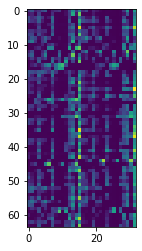

In [ ]:
plt.imshow(arr[0][0][16])
plt.show()

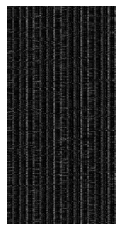

In [ ]:
plt.imshow(arr[0,0].reshape(64 * 8, 64 * 4), cmap = 'gray')

plt.axis('off')
plt.savefig("test.png", bbox_inches='tight', pad_inches = 0)
plt.show()